# SOAI Lab: Smart Home Energy Consumption Prediction


# INSTALL DEPENDENCIES


## Part 0 : Import used libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import holidays
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import L2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from prophet import Prophet
import lightgbm as lgb
from sklearn.discriminant_analysis import StandardScaler
from nbeats_pytorch.model import NBeatsNet
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

2025-01-01 20:43:18.721322: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-01 20:43:18.732457: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735760598.746113   84343 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735760598.749587   84343 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-01 20:43:18.763142: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Part 1 : Understand the data and Exploring it

### 1.1. Load the Training Data :
- The first step is to load the training data into the system. This is typically done using a data

In [2]:
# Load the training data
train_data = pd.read_csv('data/train_energy.csv')

### 1.2. Inspect the Training Data
- Inspect the training data to understand the distribution of the target variable and the features. This step is crucial

In [3]:
# Display the first few rows of the training data
print(train_data)

# Display information about the training data
print(train_data.info())

# Display summary statistics of the training data
print(train_data.describe())

# Check for missing values in the training data
print(train_data.isnull().sum())

                  DateTime  EnergyConsumption(kWh)
0      2015-11-01 00:00:00                      15
1      2015-11-01 01:00:00                      13
2      2015-11-01 02:00:00                      10
3      2015-11-01 03:00:00                       7
4      2015-11-01 04:00:00                       9
...                    ...                     ...
10244  2016-12-31 20:00:00                      37
10245  2016-12-31 21:00:00                      32
10246  2016-12-31 22:00:00                      33
10247  2016-12-31 23:00:00                      32
10248  2017-01-01 00:00:00                      27

[10249 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10249 entries, 0 to 10248
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DateTime                10249 non-null  object
 1   EnergyConsumption(kWh)  10249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 160.

### 1.3. Extracting Meaningful Informations
- Extracting temporal features form Datetime

In [4]:
# Convert DateTime to pandas datetime object
train_data['DateTime'] = pd.to_datetime(train_data['DateTime'])

## Step 2 : Data Splitting

### 2.1. Sort and Split into train and validation

In [5]:
# Sort by DateTime
train_data = train_data.sort_values(by='DateTime')

# Define split index
split_index = int(0.8 * len(train_data))

# Split into train and validation
train_df = train_data[:split_index]
val_df = train_data[split_index:]

### 2.2. Visualize Split data

/home/adel_hb/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


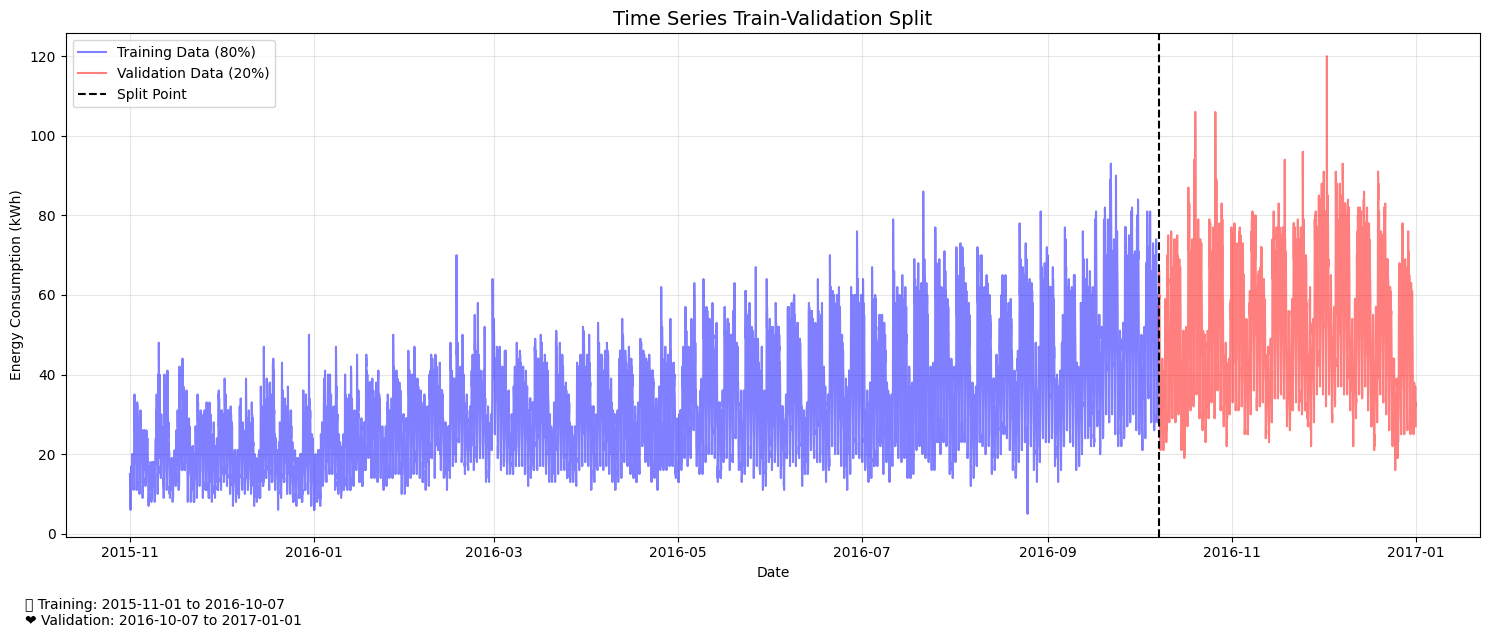

In [6]:
# Cell 2: Visualize Split
plt.figure(figsize=(15, 6))

# Plot training data
plt.plot(train_df['DateTime'], train_df['EnergyConsumption(kWh)'],
         color='blue', alpha=0.5, label='Training Data (80%)')

# Plot validation data
plt.plot(val_df['DateTime'], val_df['EnergyConsumption(kWh)'],
         color='red', alpha=0.5, label='Validation Data (20%)')

# Add split line
split_date = train_df['DateTime'].max()
plt.axvline(x=split_date, color='black', linestyle='--', label='Split Point')

# Customize plot
plt.title('Time Series Train-Validation Split', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(True, alpha=0.3)

# Add explanation
plt.figtext(0.02, -0.05, 
            f'🟢 Training: {train_df["DateTime"].min().date()} to {train_df["DateTime"].max().date()}\n' +
            f'❤️ Validation: {val_df["DateTime"].min().date()} to {val_df["DateTime"].max().date()}',
            fontsize=10, ha='left')

plt.tight_layout()
plt.show()

### 2.3. Print Split Informations

In [7]:

# Cell 3: Print Split Information
print("\nTime Series Split Summary:")
print(f"Total samples: {len(train_data)}")
print(f"Training samples: {len(train_df)} ({len(train_df)/len(train_data)*100:.1f}%)")
print(f"Validation samples: {len(val_df)} ({len(val_df)/len(train_data)*100:.1f}%)")
print(f"\nTraining period: {train_df['DateTime'].min()} to {train_df['DateTime'].max()}")
print(f"Validation period: {val_df['DateTime'].min()} to {val_df['DateTime'].max()}")

print(train_df.head())
print(val_df.head())



Time Series Split Summary:
Total samples: 10249
Training samples: 8199 (80.0%)
Validation samples: 2050 (20.0%)

Training period: 2015-11-01 00:00:00 to 2016-10-07 14:00:00
Validation period: 2016-10-07 15:00:00 to 2017-01-01 00:00:00
             DateTime  EnergyConsumption(kWh)
0 2015-11-01 00:00:00                      15
1 2015-11-01 01:00:00                      13
2 2015-11-01 02:00:00                      10
3 2015-11-01 03:00:00                       7
4 2015-11-01 04:00:00                       9
                DateTime  EnergyConsumption(kWh)
8199 2016-10-07 15:00:00                      57
8200 2016-10-07 16:00:00                      55
8201 2016-10-07 17:00:00                      49
8202 2016-10-07 18:00:00                      61
8203 2016-10-07 19:00:00                      66


### 2.4. Save data to pickle

In [8]:
splits = {
    'train': train_df,
    'validation': val_df
}

# Save to pickle
import pickle
with open('timeseries_splits.pkl', 'wb') as f:
    pickle.dump(splits, f)

print("\nSplit data saved successfully!")


Split data saved successfully!
